## Welcome to Hypothesis Test Part II

I will be using the Northwind Traders Access database to perform a hypothesis test to answer the following question.  **_Is the company spending more on shipping each year?_**<br> 
**Null Hypothesis** <br>
An order is just as likely to cost the same regardless of year <br>

**Alternative Hypothesis** <br>
The cost of the shipment is related to the year in which it is shipped<br>

**Effect Size**<br>
The USA inflation rate was 0.8% for 2014, so I am interested in any change over that effect size. 

**Variables We Are Interested in Determining the Relationship Between**<br>
The Year the order was shipped and the Cost of shipping the order. <br>

**alpha** 0.05<br>

**effect size** We will use Cohen's D to determine if the difference is large enough to worry about.  Cohen's d is determined by calculating the mean difference between the two groups, and then dividing the result by the pooled standard deviation.

**other** I want to glance at the locations orders are shipped to, if there are a lot of new countries then its not fair to compare the costs of 1 year to another.  Also, there are only 3 groups to compare.  Ideally I would like to compare more than 3 years to determine if there is a correlation between year and shipping cost.   

###  Loading Libraries

In [1]:
# add every library I will use throughout the project here
import pandas as pd
import numpy as np
import sqlite3
import scipy.stats as stat
from scipy import stats
from __future__ import print_function


#data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#for t-tests
from scipy.stats import ttest_ind

#for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison


### 1.2 Retrieve data from database

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
cursor = conn.cursor()
print("Opened database successfully")

Opened database successfully


In [3]:
for row in cursor.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    print(row)

('Employee',)
('Category',)
('Customer',)
('Shipper',)
('Supplier',)
('Order',)
('Product',)
('OrderDetail',)
('CustomerCustomerDemo',)
('CustomerDemographic',)
('Region',)
('Territory',)
('EmployeeTerritory',)


In [4]:
pd.read_sql_query("SELECT * FROM [Order] LIMIT 1;", conn)

,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France


In [5]:
freight_12 =pd.read_sql_query('''
                    SELECT Id, ShippedDate, ShipVia, Freight, ShipCountry 
                    FROM [Order] 
                    WHERE ShippedDate 
                    BETWEEN ('2012-07-04') AND ('2012-12-31')
                    ORDER BY ShippedDate
                    ''', conn)

In [6]:
freight_13 =pd.read_sql_query('''
                    SELECT Id, ShippedDate, ShipVia, Freight, ShipCountry 
                    FROM [Order] 
                    WHERE ShippedDate 
                    BETWEEN ('2013-01-01') AND ('2013-12-31')
                    ORDER BY ShippedDate
                    ''', conn)

In [7]:
freight_14 =pd.read_sql_query('''
                    SELECT Id, ShippedDate, ShipVia, Freight, ShipCountry 
                    FROM [Order] 
                    WHERE ShippedDate 
                    BETWEEN ('2014-01-01') AND ('2014-05-06')
                    ORDER BY ShippedDate
                    ''', conn)

In [8]:
exp =pd.read_sql_query('''
                    SELECT Id, ShippedDate, ShipVia, Freight, ShipCountry 
                    FROM [Order] 
                    WHERE ShippedDate 
                    BETWEEN ('2013-01-01') AND ('2014-05-06')
                    ORDER BY ShippedDate
                    ''', conn)

In [9]:
ctrl = pd.read_sql_query('''
                    SELECT Id, ShippedDate, ShipVia, Freight, ShipCountry 
                    FROM [Order] 
                    WHERE ShippedDate 
                    BETWEEN ('2012-07-04') AND ('2012-12-31')
                    ORDER BY ShippedDate
                    ''', conn)

In [10]:
freight_total = pd.read_sql_query('''
                    SELECT Id, ShippedDate, ShipVia, Freight, ShipCountry 
                    FROM [Order] 
                    ORDER BY ShippedDate
                    ''', conn)

## 2 Experiment Design

### 2.1 Setting up control and experimental groups

**_Is the shipping cost per order increasing? _** <br>

- The **control** group is comprised of orders from our earliest data from ('2012-07-04') to ('2012-12-31')<br>
- The **experimental** group is comprised of orders shipped after January 1st 2013<br>


In [11]:
ctrl.head()

,Id,ShippedDate,ShipVia,Freight,ShipCountry
0,10249,2012-07-10,1,11.61,Germany
1,10252,2012-07-11,2,51.30,Belgium
2,10250,2012-07-12,2,65.83,Brazil
3,10251,2012-07-15,1,41.34,France
4,10255,2012-07-15,3,148.33,Switzerland


In [12]:
ctrl.ShipCountry.unique()

array(['Germany', 'Belgium', 'Brazil', 'France', 'Switzerland',
       'Venezuela', 'Austria', 'Mexico', 'USA', 'Finland', 'Italy',
       'Sweden', 'Spain', 'UK', 'Ireland', 'Portugal', 'Canada',
       'Denmark', 'Poland', 'Norway'], dtype=object)

In [13]:
exp.head()

,Id,ShippedDate,ShipVia,Freight,ShipCountry
0,10392,2013-01-01,3,122.46,Austria
1,10397,2013-01-02,1,60.26,Portugal
2,10393,2013-01-03,3,126.56,USA
3,10394,2013-01-03,3,30.34,USA
4,10395,2013-01-03,1,184.41,Venezuela


In [14]:
exp.ShipCountry.unique()

array(['Austria', 'Portugal', 'USA', 'Venezuela', 'Germany', 'Denmark',
       'Italy', 'Brazil', 'France', 'Argentina', 'Canada', 'Finland',
       'Ireland', 'UK', 'Switzerland', 'Spain', 'Sweden', 'Belgium',
       'Mexico', 'Norway', 'Poland'], dtype=object)

In [15]:
same = 0
for x in exp.ShipCountry.unique():
    if x in ctrl.ShipCountry.unique():
        same += 1
else:
    print(x) 
    print(same)

Poland
20


The only newly added country is Poland

### 2.2 Checking Assumptions

#### 2.2.1 Normality


In order to perform a two-sample t-test, there are several assumptions that need to be met, the first of which is normality. We will assess this visually and also perform a normality test using the [normaltest function](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.normaltest.html#scipy.stats.normaltest) which combines measures of skew and kurtosis.

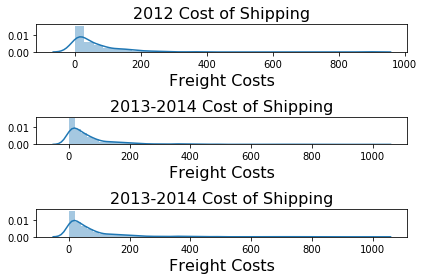

In [16]:
import warnings
warnings.filterwarnings("ignore")

plt.subplot(311)

sns.distplot(ctrl['Freight'], hist='density')
plt.title('2012 Cost of Shipping', fontsize=16)
plt.xlabel('Freight Costs', fontsize=16)

plt.subplot(312)
sns.distplot(exp['Freight'], hist='density')
plt.title('2013-2014 Cost of Shipping', fontsize=16)
plt.xlabel('Freight Costs', fontsize=16)

plt.subplot(313)
sns.distplot(exp['Freight'], hist='density')
plt.title('2013-2014 Cost of Shipping', fontsize=16)
plt.xlabel('Freight Costs', fontsize=16)

plt.tight_layout()
plt.show()

In [17]:
exp.dtypes

Id               int64
ShippedDate     object
ShipVia          int64
Freight        float64
ShipCountry     object
dtype: object

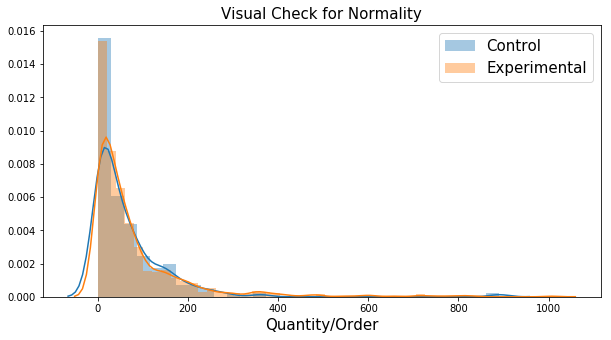

In [18]:
# visual check for normality
plt.figure(figsize=(10, 5))
sns.distplot(ctrl["Freight"], label='Control')
sns.distplot(exp["Freight"], label='Experimental',kde=True, hist=True )
plt.title('Visual Check for Normality', fontsize=15)
plt.xlabel('Quantity/Order', fontsize=15)
plt.legend(fontsize=15);

We can see that both the control and test data sets are skewed positive through visual inspection we will now check that observation using scipy's normal test function.

In [19]:
# Use scipy's normal test function for both groups
import scipy.stats as stat

print('Normality of distribution: ', stat.normaltest(ctrl["Freight"]))
print('Normality of distribution: ', stat.normaltest(exp["Freight"]))

Normality of distribution:  NormaltestResult(statistic=182.80187629604447, pvalue=2.0187238851157714e-40)
Normality of distribution:  NormaltestResult(statistic=521.1699565968439, pvalue=6.75121374571132e-114)


statistic = s^2 + k^2 = Skewness + Kurtosis  

In [20]:
stat.skewtest(ctrl["Freight"]) 

SkewtestResult(statistic=10.829427874520736, pvalue=2.4971062955913225e-27)

In [21]:
stat.kurtosistest(ctrl["Freight"])

KurtosistestResult(statistic=8.094774129436706, pvalue=5.737070526021019e-16)

If the visual was not obvious enough, such a low p-value result from the scipy.stats.normaltest results should remove all doubt.  The resulting distribution is non-normal.  The results of both the experimental and control groups are positively skewed.  We can still use this sample thanks to the **Central Limit Theorem**. 

#### 2.2.2 Independence

The next assumption is independence both within and between groups. This assumption is satisfied because we can be reasonably confident that a shipment from one year will have no affect on the cost of a shipment in another year. And one shipment is independent of another's within the same year.

#### 2.2.3 Random

The last assumption is that samples are randomly chosen, meaning every observation has an equal chance of being selected. When we create the sampling distribution of sample mean, we will use numpy's [random.choice function](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html) to ensure a random sample is generated.

### 2.3 Creating a Sampling Distribution of Sample Mean

In [22]:
sample = ctrl["Freight"]+exp["Freight"]

In [23]:
len(ctrl["Freight"])

143

In [24]:
len(exp["Freight"])

666

In [25]:
#taking a look at the means
print("control " + str(ctrl["Freight"].mean()))
print("experimental " + str(exp["Freight"].mean()))    

control 66.21636363636364
experimental 81.81093093093092


In [26]:
original_diff = abs(ctrl["Freight"].mean()-exp["Freight"].mean())
original_diff

15.594567294567284

In [27]:
#check the amount of samples and use 1/2
i = int(np.round(len(freight_total["Freight"])/2,0))
i 

415

In [28]:
sample_a = freight_total["Freight"].sample(415)
sample_b = freight_total.drop(sample_a.index)["Freight"]

In [29]:
sample_diff = np.mean(sample_a) - np.mean(sample_b)
abs(sample_diff)

12.574048192771087

In [30]:
%%time
my_diffs = []
for i in range(10000):
    sample_a = freight_total["Freight"].sample(415)
    sample_b = freight_total.drop(sample_a.index)["Freight"]
    diff = np.mean(sample_a) - np.mean(sample_b)
    my_diffs.append(diff)

CPU times: user 12.4 s, sys: 72.3 ms, total: 12.4 s
Wall time: 12.8 s


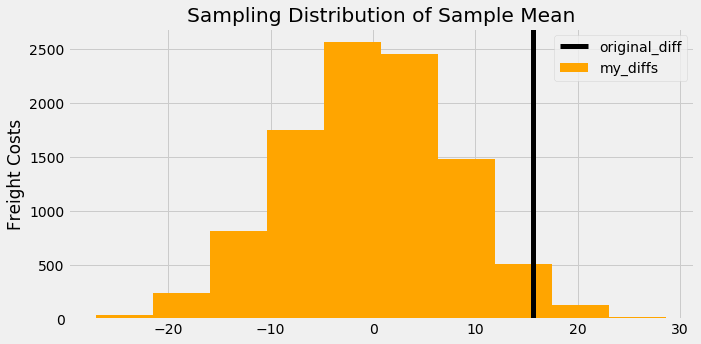

In [31]:
plt.style.use('fivethirtyeight')

fig = plt.figure(figsize=(10,5))

plt.hist(my_diffs, color="orange", label="my_diffs")
plt.axvline(original_diff, color = 'k', linewidth = 5, label="original_diff")


plt.title("Sampling Distribution of Sample Mean")
plt.ylabel("Freight Costs")
plt.legend()
plt.show()

fig.savefig("my_diffs2.png", bbox_inches="tight")


In [32]:
my_count = 0
for indv_diff in my_diffs:
    if indv_diff > original_diff:
        my_count += 1

In [33]:
my_count/len(my_diffs)

0.0273

##  Two Sample t-test

###  Hypotheses, Type 1 & Type 2 errors


The null and alternative hypotheses are as follows:

$H_o:$ There is no difference in years

$H_a:$ Freight costs are different from year to year

We set the significance level ($\alpha$) to 0.05 or 5%. In other words, this is the $\alpha$ value we are comfortable with for making a Type I error which we consider to be more serious than a Type II error. It is important to identify these errors early on so we can improve the test design. <br>

We are attempting to minimize the probability of committing a Type I error by maximizing the power (probability of making the correct decision when $H_a$ is true). <br>

Type I error: is the rejection of a true null hypothesis.  For this experiment that means the test claims the null hypothesis 'There is no difference in years' is False, when in reality it is true.  This would result in the company adjusting their business model (perhaps raising prices, and losing customers) when no adjustment is in fact necessary. 

Type II error: is the acceptance of the null hypothesis 'There is no difference in years' when it is in reality False.   This could result in the imaginary business to not allocate their finances appropriately and perhaps not charging enough to account for shipping or too much and not keeping their prices as low as competition.



In [34]:
ttest_ind(exp["Freight"].values, ctrl["Freight"].values )

Ttest_indResult(statistic=1.4374026129654247, pvalue=0.15099124016465792)

**The 0.15 p-value shows there is not a statistically signifigant difference.  We have failed to reject the null hypothesis.**

In [35]:
# create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# combine functions to create a sample distribution
# create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
        
    return sample_dist

In [36]:
ctrl_sample = create_sample_distribution(ctrl["Freight"])
exp_sample = create_sample_distribution(exp["Freight"])

In [37]:
ttest_ind(exp["Freight"].values, ctrl["Freight"].values )

Ttest_indResult(statistic=1.4374026129654247, pvalue=0.15099124016465792)

In [38]:
# Calculate Sample Variance
def variance(sample):
    sample_mean = np.mean(sample)
    return sum([(i - sample_mean)**2 for i in sample])

def sample_variance(sample1, sample2):
    n_1, n_2 = len(sample1), len(sample2)
    var_1, var_2 = variance(sample1), variance(sample2)
    return (var_1 + var_2)/((n_1 + n_2)-2)

In [39]:
# Calculate 2 sample t-statistc
def twosample_tstatistic(exp, ctrl):
    exp_mean, ctrl_mean = np.mean(exp), np.mean(ctrl)
    samp_var = sample_variance(exp, ctrl)
    n_e, n_c = len(exp), len(ctrl)
    num = exp_mean - ctrl_mean
    denom = np.sqrt(samp_var * ((1/n_e)+(1/n_c)))
    return num / denom

t_stat = twosample_tstatistic(exp["Freight"], ctrl["Freight"])
t_stat

1.4374026129654252

Given the above information we can calculate area under the curve to find p-value

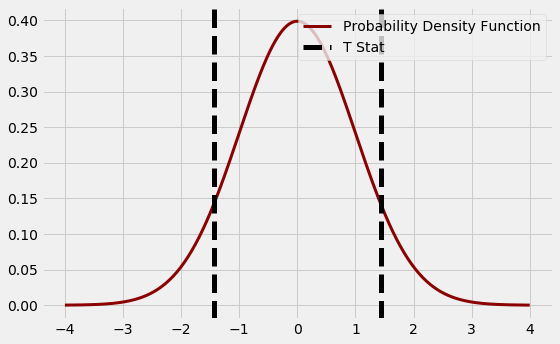

In [40]:
# Visualize test statistic

def visualize_t(t_stat, n_control, n_experimental):

    # initialize a matplotlib "figure"
    fig = plt.figure(figsize=(8,5))
    ax = fig.gca()
    
    # generate points on the x axis between -4 and 4:
    xs = np.linspace(-4, 4, 500)

    # use stats.t.pdf to get values on the probability density function for the t-distribution
    
    ys= stats.t.pdf(xs, (n_control+n_experimental-2), 0, 1)
    ax.plot(xs, ys, linewidth=3, color='darkred', label="Probability Density Function")

    ax.axvline(t_stat, color='black', linestyle='--', lw=5)
    ax.axvline(-t_stat, color='black', linestyle='--', lw=5, label= "T Stat")
    
    plt.legend(loc=1)
    plt.tight_layout()
    plt.show()
    return None

n_control = len(ctrl_sample)
n_experimental = len(exp_sample)
visualize_t(t_stat, n_control, n_experimental)

### 3.2 Welch's t-test

In [41]:
def welch_ttest(x, y): 
    ## Welch-Satterthwaite Degrees of Freedom ##
    dof = (x.var()/x.size + y.var()/y.size)**2 / ((x.var()/x.size)**2 / (x.size-1) + (y.var()/y.size)**2 / (y.size-1))
   
    t, p = stats.ttest_ind(x, y, equal_var = False)
    
    print("\n",
          f"Welch's t-test= {t:.4f}", "\n",
          f"p-value = {p:.4f}", "\n",
          f"Welch-Satterthwaite Degrees of Freedom= {dof:.4f}")

welch_ttest(ctrl["Freight"], exp["Freight"])


 Welch's t-test= -1.6643 
 p-value = 0.0973 
 Welch-Satterthwaite Degrees of Freedom= 248.5884


### 3.3 Effect Size

## Cohen's $d$

Cohen’s D is one of the most common ways to measure effect size.  As an effect size, Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups on that variable. 

Cohen’s d is similar to the unpaired t test t value. It relies on Standard Deviations instead of Standard Errors

The basic formula to calculate Cohen’s $d$ is:

> ** $d$ = effect size (difference of means) / pooled standard deviation **

The denominator is the **standardiser**, and it is important to select the most appropriate one for a given dataset. The pooled standard deviation is the average spread of all data points around their group mean (not the overall mean). 

#### **other considerations for determining effect size** <br>
**Cohen's d** is the appropriate effect size measure if two groups have similar standard deviations and are of the same size. **Glass' delta**, which uses only the standard deviation of the control group, is an alternative measure if each group has a different standard deviation. **Hedges' g**, which provides a measure of effect size weighted according to the relative size of each sample, is an alternative where there are different sample sizes.

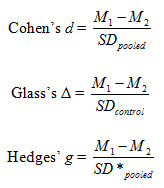

In [42]:
from IPython.display import Image
Image("Cohen_Glass_Hedge.jpg")

In [43]:
len(ctrl_sample)

1000

In [44]:
len(exp_sample)

1000

In [45]:
np.mean(ctrl_sample)

66.35514988000003

In [46]:
np.std(ctrl_sample)

4.296641836990183

In [47]:
np.std(exp_sample)

5.331161315571275

In [48]:
def Cohen_d(group1, group2):
    # Compute Cohen's d.
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [49]:
ctrl_sample = np.array(ctrl_sample)
exp_sample = np.array(exp_sample)

The denominator of the equation is the standardiser and, it is important to select the most appropriate standardiser for a given dataset because it can have a big influence on Cohen’s d.

In [50]:
abs(Cohen_d(ctrl_sample,exp_sample))

3.234093707906961

In [51]:
def Glass(group1, group2):
    # Compute Glass's delta.
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled threshold as shown earlier
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d



parameters 
small effect = 0 to .2 std 
med. effect = .2 to .8 std 
large effect > .8 std 

Our Cohen's d value is 3.08; therefore we would categorize the difference as a large effect size. **However**, we have already determined that there is not a significant difference between the years.<br>

I will use **Glass's Delta** to check the effect size.  Which is similar to Cohen's D but it uses only the control groups standard deviation not the pooled standard deviation.  

```If the standard deviations of the two groups differ, then the homogeneity of variance assumption is violated and pooling the standard deviations is not appropriate. One solution is to insert the standard deviation of the control group into the equation and calculate Glass's delta (Glass et al. 1981, p.29). The logic is that the standard deviation of the control group is untainted by the effects of the treatment and will therefore more closely reflect the population standard deviation. The strength of this assumption is directly proportional to the size of the control group. The larger the control group, the more it is likely to resemble the population from which it was drawn.``` [polyu.edu.hk](http://www.polyu.edu.hk/mm/effectsizefaqs/effect_size_equations2.html)

Cohen's d = (81.82788 - 66.245) ⁄ 4.994709 = 3.119877.

Gates' delta = (81.82788 - 66.245) ⁄ 4.333427 = 3.595972.

Hedges' g = (81.82788 - 66.245) ⁄ 4.994709 = 3.119877

### 3.4 ANOVA

In [52]:
conn = sqlite3.connect('Northwind_small.sqlite', detect_types=sqlite3.PARSE_DECLTYPES|sqlite3.PARSE_COLNAMES)


In [53]:
df = pd.read_sql_query('''
                    SELECT Id, ShippedDate, ShipVia, Freight, ShipCountry 
                    FROM [Order]
                    Where ShippedDate IS NOT NULL
                    ORDER BY ShippedDate
                    ''', conn)

In [54]:
df.head()

,Id,ShippedDate,ShipVia,Freight,ShipCountry
0,10249,2012-07-10,1,11.61,Germany
1,10252,2012-07-11,2,51.30,Belgium
2,10250,2012-07-12,2,65.83,Brazil
3,10251,2012-07-15,1,41.34,France
4,10255,2012-07-15,3,148.33,Switzerland


In [55]:
import datetime as dt

In [56]:
df['ShippedDate'] =  pd.to_datetime(df['ShippedDate'],
                              format='%Y-%m-%d')

In [58]:
df.head()

,Id,ShippedDate,ShipVia,Freight,ShipCountry
0,10249,2012-07-10,1,11.61,Germany
1,10252,2012-07-11,2,51.30,Belgium
2,10250,2012-07-12,2,65.83,Brazil
3,10251,2012-07-15,1,41.34,France
4,10255,2012-07-15,3,148.33,Switzerland


In [60]:
df['Year'] = df['ShippedDate'].dt.strftime('%Y')

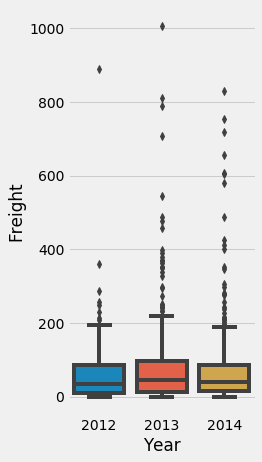

In [61]:
fig, ax = plt.subplots()
fig.set_size_inches((3,7))
sns.boxplot(x='Year',y='Freight',data=df,ax=ax)


plt.show()



In [62]:
# wrap with C() to indicate categorical variable
results = ols('Freight ~ C(Year)', data=df).fit()

In [63]:
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

                sum_sq     df         F    PR(>F)
C(Year)   2.961141e+04    2.0  1.067277  0.344429
Residual  1.118116e+07  806.0       NaN       NaN


Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 2012   2013   14.598  -12.3658 41.5619 False 
 2012   2014  17.0745  -11.5658 45.7149 False 
 2013   2014   2.4765  -19.377   24.33  False 
----------------------------------------------


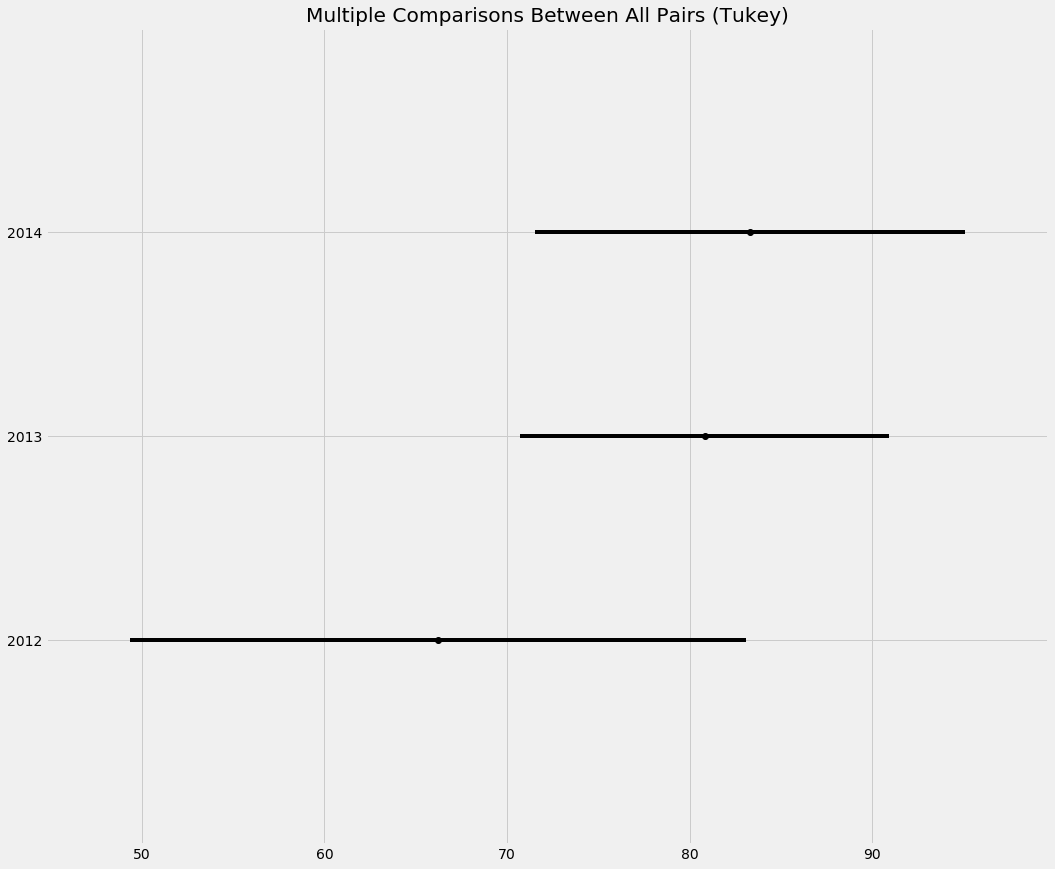

In [66]:
mc = MultiComparison(df['Freight'], df['Year'])
mc_results = mc.tukeyhsd()
print(mc_results)

mc_results = mc_results.plot_simultaneous(figsize=(16,14))
plt.show()
mc_results.savefig("mc_results2.png", bbox_inches='tight')

Unable to reject null hypothesis.  There is not a statistically significant correlation between the year and freight cost.